# Final Project Submission

- Student name: Sabina Bains
- Student pace: Self Paced
- Scheduled project review date / time: 7/29 11am EST
- Instructor name: Claude Fried

# Business Understanding

Over the past couple of months, Twitter has been in the headlines for the potential acquistion of their company from Elon Musk. This has upset many people, as Musk plans to reduce the level of moderation Twitter currently has on potentially harmful tweets.

BeKind Org. believes this change will likely lead to a massive increase in hate speech and misinformation, and will negatively affect users. They therefore would like our help to create the model behind a browser extension that can flag tweets that are considered cyberbullying. This way, users have the option to hide tweets from their feed. 

We will tackle this with a supervised learning approach, therefore training our models a [dataset](https://www.kaggle.com/code/anayad/classifying-cyberbullying-tweets/data) of 47K tweets that have already been flagged for cyberbullying type. Since this analysis involves natural language processing, we will have to process our data accordingly.

We will first train a multinomial naive bayes model, then compare our model's accuracy with recurrent neural networks to see which performs better on unseen data. The final model will then be used in the extension to sift through tweets and flag by type of cyberbullying.

# Data Understanding

#### Reading in Necessary Packages

In [1]:
# importing standard packages
import pandas as pd
import re
import numpy as np

# importing packagest for NLP and Multinomial Naive Bayes
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams

# importing packages for plotting results
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl

# changing colors of output
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR


# importing keras packages for neural networks
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

# importing warning package to ignore
import warnings
warnings.filterwarnings('ignore')

#### Reading in Data

In [2]:
# reading in data
df = pd.read_csv('data/cyberbullying_tweets.csv')


# replacing offensive words
df.tweet_text = df.tweet_text.str.replace('ggers','xxxxx')
df.tweet_text = df.tweet_text.str.replace('gger','xxxx')

#### Understanding Labels

In [3]:
# checking distribution of target values - looks like a balanced dataset
pd.DataFrame(df.cyberbullying_type.value_counts(normalize=True))

,cyberbullying_type
religion,0.167701
age,0.167575
gender,0.167177
ethnicity,0.166925
not_cyberbullying,0.166590
other_cyberbullying,0.164032


In [4]:
# standardizing words to all be lowercase
def lowercase(x):
    return x.lower()

df.tweet_text = df.tweet_text.apply(lowercase)

In [5]:
# tokenizing words in df to inspect differences in cyberbullying classes
def tokenize(x):
    token_pattern = r"(?u)\b\w\w+\b"
    tokenizer = RegexpTokenizer(token_pattern)
    return tokenizer.tokenize(x)

df['tokens'] = df.tweet_text.apply(tokenize)

In [6]:
# creating function to remove stopwords
stopwords_list = stopwords.words('english')

def remove_stopwords(token_list):
    return [word for word in token_list if word not in stopwords_list]

df.tokens = df.tokens.apply(remove_stopwords)

In [7]:
# Above we can see we need to stem the data (muslim vs. muslims). creating here
stemmer = SnowballStemmer(language="english")

def stem(tweets):
    return [stemmer.stem(tweet) for tweet in tweets]

df.tokens = df.tokens.apply(stem)

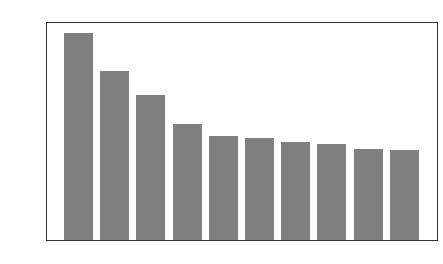

In [8]:
# looking at top words in entire dataset, regardless of label
total_top_10 = FreqDist(df.tokens.explode()).most_common(10)

tokens = [word[0] for word in total_top_10]
counts = [value[1] for value in total_top_10]

fig = plt.figure(figsize=(7,4))
plt.bar(tokens,counts, color= 'grey')
plt.title('Top Tokens')
plt.show()

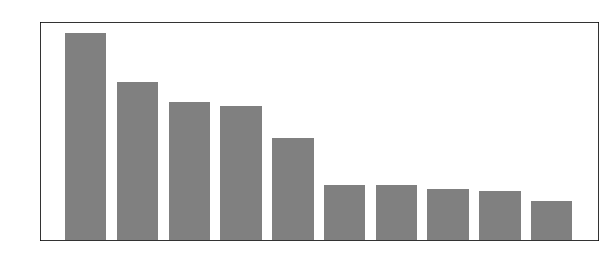

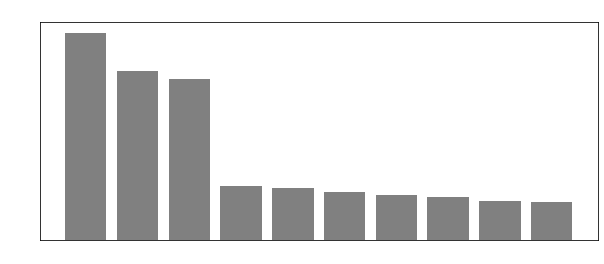

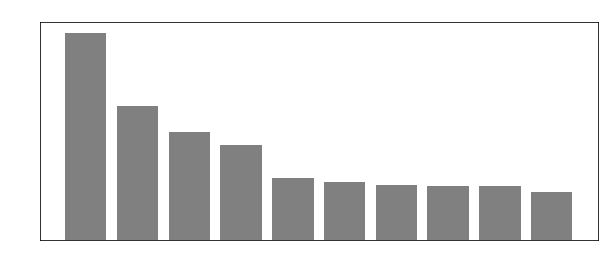

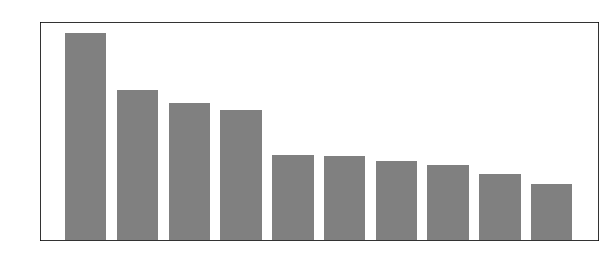

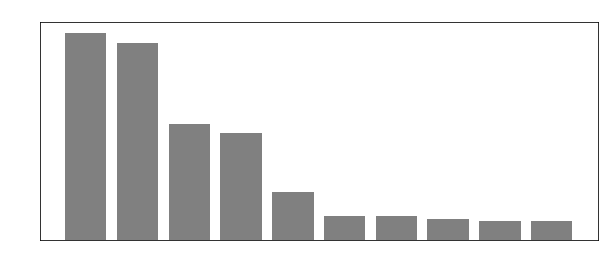

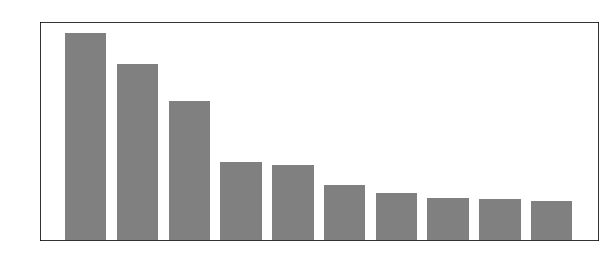

In [9]:
# Creating frequency distributions for each label to visually inspect most common words in each label
freq_dict = {}

for target in df.cyberbullying_type.unique():
    freq_dict[target] = FreqDist(df.loc[df.cyberbullying_type == target].tokens.explode())
    
    top_10 = list(zip(*freq_dict[target].most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    fig = plt.figure(figsize=(10,4))
    plt.bar(tokens,counts, color = 'grey')
    plt.title('Top tokens for '+target)
    plt.show()

#### Observing Bigrams and Trigrams

In [10]:
# creating bigrams
def bigram(tweet):
    return [' '.join(word) for word in ngrams(tweet, 2)]

#creating trigrams
def _3gram(tweet):
    return [' '.join(word) for word in ngrams(tweet, 3)]

#adding to df
df['bigram'] = df.tokens.apply(bigram)
df['_3gram'] = df.tokens.apply(_3gram)

In [11]:
# looking at most common trigrams in dataset
FreqDist(df._3gram.explode()).most_common(10)

[('bulli high school', 1539),
 (nan, 1127),
 ('dumb ass nixxxx', 1104),
 ('fuck obama dumb', 979),
 ('obama dumb ass', 966),
 ('tayyoung_ fuck obama', 956),
 ('girl bulli high', 824),
 ('high school bulli', 653),
 ('rt tayyoung_ fuck', 456),
 ('girl high school', 415)]

#### Splitting Tweets and Labels into two dataframes

In [12]:
# df of features only
X = pd.DataFrame(df.tweet_text)

# df of labels
y = df.cyberbullying_type

#### Performing Train Test Split for Data Validation

In [13]:
# Split the data into Train and Test, so we can later validate our model on "unseen" data.
# We must split before vectorizing, to simulate the real world where our future data may contain words we have not seen before
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# MODELING

We will first try classify cyberbullying using a multinomial bayes classifier. 

In [14]:
# creating a function to evaluate models
def evaluate_multinomialnb(tfidf, model, X_train, X_test):
    
    # vectorizing data and fitting on training data
    X_train_v = tfidf.fit_transform(X_train.tweet_text)
    X_test_v = tfidf.transform(X_test.tweet_text)
    
    # computing mean accuracy
    train_acc = cross_val_score(model, X_train_v, y_train).mean()
    test_acc = cross_val_score(model, X_test_v, y_test).mean()

    # printing result
    print('Training Accuracy: {:.1%}'.format(train_acc))
    print('Testing Accuracy: {:.1%}'.format(test_acc))

#### Baseline Model

In [15]:
# initializing basic TFIDF vectorizer with 50 words with highest tfidf values
tfidf_1 = TfidfVectorizer(max_features=50)
model_1 = MultinomialNB()

evaluate_multinomialnb(tfidf_1, model_1, X_train, X_test)

print('''\nOur baseline model performs ok, if we were to randomly classify cyberbullying we would get an accuracy of 16.6%, whereas our model
has an accuracy of over 3x better. However this model will still predict correctly only about half the time. Let's try to improve it by
removing stopwords.''')

Training Accuracy: 56.6%
Testing Accuracy: 55.0%

Our baseline model performs ok, if we were to randomly classify cyberbullying we would get an accuracy of 16.6%, whereas our model
has an accuracy of over 3x better. However this model will still predict correctly only about half the time. Let's try to improve it by
removing stopwords.


#### Model #2 - Removing Stopwords

In [16]:
# Instantiate the vectorizer with stopwords removed
tfidf_2 = TfidfVectorizer(
    max_features=50,
    stop_words=stopwords_list
)

evaluate_multinomialnb(tfidf_2, model_1, X_train, X_test)

print('''\n Our model has significantly improved once removing stopwords. Let's continue to tweak by stemming words, as we saw earlier that some
words are considered different when they have the same underlying meaning''')

Training Accuracy: 65.2%
Testing Accuracy: 63.6%

 Our model has significantly improved once removing stopwords. Let's continue to tweak by stemming words, as we saw earlier that some
words are considered different when they have the same underlying meaning


#### Model #3 - Removed Stopwords and Stemmed

In [17]:
# Instantiate the vectorizer with stemmed words
tfidf_3 = TfidfVectorizer(
    max_features = 50,
    stop_words = stopwords_list,
    token_pattern = r"(?u)\b\w+\b" #Changing tokens to include single letter words since people on twitter type in shorthand
)
# calling function to evaluate
evaluate_multinomialnb(tfidf_3, model_1, X_train, X_test)

print('''\n Still improving slightly. lets add bigrams and increase max_features''')

Training Accuracy: 66.0%
Testing Accuracy: 64.3%

 Still improving slightly. lets add bigrams and increase max_features


#### Model #4 - Removed Stopwords and added Bigrams

In [18]:
# Instantiate the vectorizer with added Bigrams. also increased max_features.
tfidf_4 = TfidfVectorizer(
    max_features = 80,
    stop_words = stopwords_list,
    token_pattern = r"(?u)\b\w+\b",
    ngram_range = (1, 2)
)
# calling function to evaluate
evaluate_multinomialnb(tfidf_4, model_1, X_train, X_test)

print('''\n Lets do some feature engineering to see if we can improve accuracy while taking order of words into account''')

Training Accuracy: 70.7%
Testing Accuracy: 68.8%

 Lets do some feature engineering to see if we can improve accuracy while taking order of words into account


#### Model #5 - feature engineering

In [19]:
# creating a column that notes if a tweet has a link or not
def has_link(x):
    if 'https' in x:
        return 1
    else:
        return 0

X_train['has_link'] = X_train.tweet_text.apply(has_link)
X_test['has_link'] = X_test.tweet_text.apply(has_link)

In [20]:
# creating a column that notes if a tweet is a reply or not
def is_reply(x):
    if '@' in x:
        return 1    
    else:
        return 0

# applying new features to data
X_train['is_reply'] = X_train.tweet_text.apply(is_reply)
X_test['is_reply'] = X_test.tweet_text.apply(is_reply)

# resetting indices
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

In [21]:
# fitting and transforming X_train with tfidf used in previous model
X_train_v2 = tfidf_4.fit_transform(X_train.tweet_text)

# adding engineered features to X_train
X_train_2 = pd.DataFrame.sparse.from_spmatrix(X_train_v2, columns=tfidf_4.get_feature_names())
X_train_2 = pd.concat([X_train_2, X_train[['has_link', 'is_reply']]], axis=1)

# transforming X_test
X_test_v2 = tfidf_4.transform(X_test.tweet_text)

# adding engineered features to X_test
X_test_2 = pd.DataFrame.sparse.from_spmatrix(X_test_v2, columns=tfidf_4.get_feature_names())
X_test_2 = pd.concat([X_test_2, X_test[['has_link', 'is_reply']]], axis=1)
    
# getting accuracy of X_train and X_test
train_acc = cross_val_score(model_1, X_train_2, y_train).mean()
test_acc = cross_val_score(model_1, X_test_2, y_test).mean()

#printing result
print('Training Accuracy: {:.1%}'.format(train_acc))
print('Testing Accuracy: {:.1%}'.format(test_acc))
print('''\nHere we have improved our model even more. Testing accuracy indicates we are not overfitting at all.
We can continue to add more features and start tuning, but let's first take a look at recurrent neural networks and see if we
can get any promising results that way.''')

Training Accuracy: 73.5%
Testing Accuracy: 72.3%

Here we have improved our model even more. Testing accuracy indicates we are not overfitting at all.
We can continue to add more features and start tuning, but let's first take a look at recurrent neural networks and see if we
can get any promising results that way.


### Trying Recurrent Neural Networks


Bigrams and trigrams have clearly improved the model's ability to classify cyberbulling, however we are still losing knowledge with our bag of words approach, rather than having the ability to understand the complete order of the sentence. A recurrent neural network can help with this, and potentially give us a higher accuracy. 

Recurrent Neural Networks take in the output of the first word, and use it as the input for the next run.

In [22]:
# tokenizing X_train_data
tweets = X_train.tweet_text.apply(tokenize)

# creating total vocabulary by using a set and comprehension. This will be used for embedding layer
total_vocabulary = set(word.lower() for tweet in tweets for word in tweet)

In [23]:
# encoding labels
y_train_d = pd.get_dummies(y_train).values
y_test_d = pd.get_dummies(y_test).values

# use keras to create a Tokenizer object
tokenizer = text.Tokenizer(num_words=20000)  # limiting number of words for processing sake

# giving each word a unique integer
tokenizer.fit_on_texts(list(X_train.tweet_text))

# creating a sequence of the created unique integers for each tweet for X_train
tokenized_X_train = tokenizer.texts_to_sequences(X_train.tweet_text)

# Transforming X_test as well
tokenized_X_test  = tokenizer.texts_to_sequences(X_test.tweet_text)

# finally, padding each tweet in X_train so they are all the length of the longest tweet, in this case 100 words. 
X_train_pad = sequence.pad_sequences(tokenized_X_train, maxlen=140)

# padding test data
X_test_pad = sequence.pad_sequences(tokenized_X_test, maxlen=140)

In [24]:
# Running first Recurrent Neural Network Model
rnn_model_1 = Sequential() # Initializing sequential rnn_model_1
rnn_model_1.add(Embedding(len(total_vocabulary), 140)) # Embedding to help with Dimensionality Reduction. the layer creates it's own vectors based on the language in the text data it trains on, and then passes that information on to the LSTM network one word at a time. First input is length of the total tweet vocab, and second input is the length of the tweets in words (we capped at 140 here since that is how long most tweets are capped at)
rnn_model_1.add(LSTM(25, return_sequences=True)) # Adding the Long Short Term Memory Cells layer (RNN), gives us the ability to forget information that is less important, so our rnn_model_1 can remember only what matters, and avoid vanishing or exploding gradients
rnn_model_1.add(GlobalMaxPool1D()) # Downsamples the input representation by taking the maximum value over the time dimension.
rnn_model_1.add(Dense(50, activation='relu')) # Adding hidden layer with 50 neurons and ReLu activation because it is effective when derivatives are very small. Since learning happens very slowly because weights are affected very little.
rnn_model_1.add(Dense(50, activation='relu')) # Adding another hidden layer with 50 neurons and Relu activation
rnn_model_1.add(Dense(6, activation='softmax'))  # 6 neurons because we have 6 labels. We use softmax activation so that the network will output a vector of predictions, where each element's value corresponds to the percentage chance that the example is the class that corresponds to that element, and where the sum of all elements in the output vector is 1.

In [25]:
rnn_model_1.compile(loss='categorical_crossentropy', # using this loss function because this is a multiclass problem
              optimizer='adam', # an extension to stochastic gradient descent
              metrics=['accuracy']) # using accuracy to evaluate our models
rnn_model_1.summary() # printing summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 140)         7091140   
_________________________________________________________________
lstm (LSTM)                  (None, None, 25)          16600     
_________________________________________________________________
global_max_pooling1d (Global (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 7,111,896
Trainable params: 7,111,896
Non-trainable params: 0
______________________________________________

In [26]:
rnn_model_1.fit(X_train_pad, y_train_d, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
1006/1006 [==============================] - 96s 96ms/step - loss: 0.5757 - accuracy: 0.7652 - val_loss: 0.4029 - val_accuracy: 0.8409
Epoch 2/5
1006/1006 [==============================] - 88s 87ms/step - loss: 0.3116 - accuracy: 0.8756 - val_loss: 0.3884 - val_accuracy: 0.8451
Epoch 3/5
1006/1006 [==============================] - 88s 88ms/step - loss: 0.2288 - accuracy: 0.9107 - val_loss: 0.4637 - val_accuracy: 0.8272
Epoch 4/5
1006/1006 [==============================] - 90s 90ms/step - loss: 0.1721 - accuracy: 0.9308 - val_loss: 0.5499 - val_accuracy: 0.8197
Epoch 5/5
1006/1006 [==============================] - 89s 89ms/step - loss: 0.1389 - accuracy: 0.9411 - val_loss: 0.5861 - val_accuracy: 0.8133


In [27]:
'''
Our first RNN model had a high accuracy of 94% on it's training data, but a significantly lower validation accuracy of 82%. this indicates
we are indeed overfitting. Let's try adding dropout layers.
'''

"\nOur first RNN model had a high accuracy of 94% on it's training data, but a significantly lower validation accuracy of 82%. this indicates\nwe are indeed overfitting. Let's try adding dropout layers.\n"

In [28]:
# Running second Recurrent Neural Network rnn_model_2
rnn_model_2 = Sequential()

rnn_model_2.add(Embedding(len(total_vocabulary), 140))
rnn_model_2.add(LSTM(25, return_sequences=True))
rnn_model_2.add(GlobalMaxPool1D())
rnn_model_2.add(Dropout(0.5)) # randomly ignoring half of the neurons for the upcoming layer to prevent overfitting
rnn_model_2.add(Dense(50, activation='relu'))
rnn_model_2.add(Dropout(0.5))
rnn_model_2.add(Dense(50, activation='relu'))
rnn_model_2.add(Dropout(0.5))
rnn_model_2.add(Dense(6, activation='softmax'))

In [29]:
# compiling second model and printing summary
rnn_model_2.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 140)         7091140   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 25)          16600     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)               

In [30]:
# running second model
history = rnn_model_2.fit(X_train_pad, y_train_d, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
1006/1006 [==============================] - 89s 89ms/step - loss: 0.9103 - accuracy: 0.6275 - val_loss: 0.4823 - val_accuracy: 0.8035
Epoch 2/5
1006/1006 [==============================] - 90s 89ms/step - loss: 0.5227 - accuracy: 0.7788 - val_loss: 0.4502 - val_accuracy: 0.8303
Epoch 3/5
1006/1006 [==============================] - 90s 90ms/step - loss: 0.4506 - accuracy: 0.8097 - val_loss: 0.4671 - val_accuracy: 0.8214
Epoch 4/5
1006/1006 [==============================] - 89s 89ms/step - loss: 0.4095 - accuracy: 0.8269 - val_loss: 0.4758 - val_accuracy: 0.8286
Epoch 5/5
1006/1006 [==============================] - 83s 83ms/step - loss: 0.3782 - accuracy: 0.8395 - val_loss: 0.4705 - val_accuracy: 0.8353


In [31]:
# Running next Recurrent Neural Network rnn_model_3
rnn_model_3 = Sequential()

rnn_model_3.add(Embedding(len(total_vocabulary), 140))
rnn_model_3.add(LSTM(25, kernel_regularizer=regularizers.l2(0.005), return_sequences=True))
rnn_model_3.add(GlobalMaxPool1D())
rnn_model_3.add(Dropout(0.5)) # randomly ignoring half of the neurons from the layer to prevent overfitting
rnn_model_3.add(Dense(50, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
rnn_model_3.add(Dropout(0.5))
rnn_model_3.add(Dense(50, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
rnn_model_3.add(Dropout(0.5))
rnn_model_3.add(Dense(6, activation='softmax'))

In [32]:
# compiling second model and printing summary
rnn_model_3.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 140)         7091140   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 25)          16600     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 25)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)               

In [33]:
# running second model
history_rnn_3 = rnn_model_3.fit(X_train_pad, y_train_d, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
1006/1006 [==============================] - 90s 89ms/step - loss: 1.3658 - accuracy: 0.4484 - val_loss: 0.9992 - val_accuracy: 0.6553
Epoch 2/5
1006/1006 [==============================] - 83s 82ms/step - loss: 0.8561 - accuracy: 0.6794 - val_loss: 0.6981 - val_accuracy: 0.7425
Epoch 3/5
1006/1006 [==============================] - 83s 82ms/step - loss: 0.7027 - accuracy: 0.7397 - val_loss: 0.6440 - val_accuracy: 0.7744
Epoch 4/5
1006/1006 [==============================] - 84s 83ms/step - loss: 0.6508 - accuracy: 0.7584 - val_loss: 0.6524 - val_accuracy: 0.7780
Epoch 5/5
1006/1006 [==============================] - 88s 87ms/step - loss: 0.5965 - accuracy: 0.7727 - val_loss: 0.6414 - val_accuracy: 0.7755


In [34]:
# Running next Recurrent Neural Network rnn_model_4
rnn_model_4 = Sequential()

rnn_model_4.add(Embedding(len(total_vocabulary), 140))
rnn_model_4.add(LSTM(25, kernel_regularizer=regularizers.l2(0.05), return_sequences=True))
rnn_model_4.add(GlobalMaxPool1D())
rnn_model_4.add(Dropout(0.5)) # randomly ignoring half of the neurons from the layer to prevent overfitting
rnn_model_4.add(Dense(50, kernel_regularizer=regularizers.l2(0.05), activation='relu'))
rnn_model_4.add(Dropout(0.5))
rnn_model_4.add(Dense(6, activation='softmax'))

In [35]:
# compiling second model and printing summary
rnn_model_4.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 140)         7091140   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 25)          16600     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 25)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                

In [36]:
# running second model
history_rnn_4 = rnn_model_4.fit(X_train_pad, y_train_d, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
1006/1006 [==============================] - 112s 112ms/step - loss: 1.9698 - accuracy: 0.3057 - val_loss: 1.3980 - val_accuracy: 0.3567
Epoch 2/5
1006/1006 [==============================] - 91s 90ms/step - loss: 1.3903 - accuracy: 0.3559 - val_loss: 1.3197 - val_accuracy: 0.5250
Epoch 3/5
1006/1006 [==============================] - 107s 106ms/step - loss: 1.1350 - accuracy: 0.5263 - val_loss: 0.9243 - val_accuracy: 0.5949
Epoch 4/5
1006/1006 [==============================] - 97s 97ms/step - loss: 0.9577 - accuracy: 0.5927 - val_loss: 0.8679 - val_accuracy: 0.6234
Epoch 5/5
1006/1006 [==============================] - 90s 89ms/step - loss: 0.8470 - accuracy: 0.6207 - val_loss: 0.8180 - val_accuracy: 0.6925


In [51]:
# Running second Recurrent Neural Network rnn_model_5
rnn_model_5 = Sequential()

rnn_model_5.add(Embedding(len(total_vocabulary), 140))
rnn_model_5.add(LSTM(50, return_sequences=True))
rnn_model_5.add(GlobalMaxPool1D())
rnn_model_5.add(Dropout(0.5)) # randomly ignoring half of the neurons for the upcoming layer to prevent overfitting
rnn_model_5.add(Dense(50, kernel_regularizer=regularizers.l2(0.00005), activation='relu'))
rnn_model_5.add(Dropout(0.5))
rnn_model_5.add(Dense(50, kernel_regularizer=regularizers.l2(0.0005), activation='relu'))
rnn_model_5.add(Dropout(0.5))
rnn_model_5.add(Dense(6, activation='softmax'))

In [52]:
# compiling second model and printing summary
rnn_model_5.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn_model_5.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 140)         7091140   
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 50)          38200     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 50)                0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_19 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)               

In [53]:
history = rnn_model_5.fit(X_train_pad, y_train_d, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
1006/1006 [==============================] - 116s 115ms/step - loss: 0.9028 - accuracy: 0.6420 - val_loss: 0.5190 - val_accuracy: 0.7836
Epoch 2/5
1006/1006 [==============================] - 118s 118ms/step - loss: 0.5313 - accuracy: 0.7770 - val_loss: 0.4934 - val_accuracy: 0.7898
Epoch 3/5
1006/1006 [==============================] - 108s 107ms/step - loss: 0.4587 - accuracy: 0.7970 - val_loss: 0.5124 - val_accuracy: 0.7699
Epoch 4/5
1006/1006 [==============================] - 114s 113ms/step - loss: 0.4146 - accuracy: 0.8055 - val_loss: 0.4832 - val_accuracy: 0.7984
Epoch 5/5
1006/1006 [==============================] - 120s 120ms/step - loss: 0.3837 - accuracy: 0.8168 - val_loss: 0.5209 - val_accuracy: 0.7973


# Model Evaluation

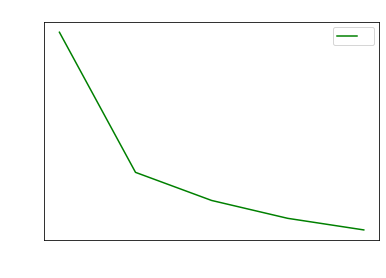

In [40]:
# Plot the loss vs the number of epoch
history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss for RNN Model 5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend('Loss')
plt.show()

In [71]:
# Now that we have our final trained model, we will use the X_test to predict our y_pred values, since this data has no data leakage.
y_pred = np.argmax(rnn_model_5.predict(X_test_pad), axis = -1)

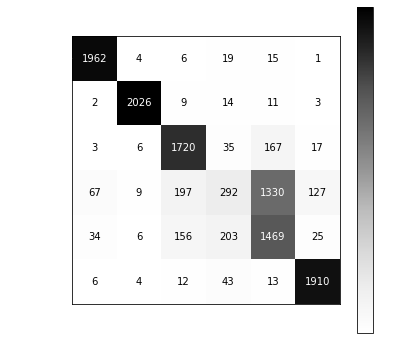

In [72]:
# need to rearrange y to be in one column for confusion matrix 
y_test_labels = np.argmax(y_test_d, axis=1)
y_train_labels = np.argmax(y_train_d, axis=1)

# creating a confusion matrix to observe accuracy between cyberbullying types
cm = confusion_matrix(y_labels, y_pred)

# displaying final cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Age','Ethnicity','Gender','None','Other','Religion'])
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap=plt.cm.Greys, ax = ax)

In [70]:
train_loss, train_acc = rnn_model_5.evaluate(X_train_pad, y_train_d)
test_loss, test_acc = rnn_model_5.evaluate(X_test_pad, y_test_d)

print('''
Final Train Accuracy = {:.1%}
Final Test Accuracy = {:.1%}
'''.format(train_acc,test_acc))

373/373 [==============================] - 6s 16ms/step - loss: 0.5402 - accuracy: 0.7866

Final Train Accuracy = 84.1%
Final Test Accuracy = 78.7%



Final Model Evaluation:

# Conclusions and Next Steps

In the end, our Recursive Neural Network Model outperformed our Multinomial Naive Bayes Model in terms of accuracy on both Training and Testing data. Our first Sequential model had an accuracy of 95% on it's training data, but was severely overfitting as we saw with our low Testing data score. With each iteration we worked towards reducing overfitting, through the dropout method and L2 regularization. In the end, we settled on our final model with a Training Accuracy of XX% and Testing Accuracy of XX%. 

Next steps to consider when working on this project would be to create a pipeline to find the optimal testing accuracy, as it could be higher. I would also look into the low accuracy score between "No Cyberbullying" and "Other Cyberbullying", as our confusion matrix shows that the model could not identify differences in these tweets as well. This would involve potentially gathering more data, or looking more into the accuracy of labeling for those two categories. I would also incorporate data into this model that would have the ability to flag fake news, as these types of tweets could increase with less moderation on twitter, and are dangerous to our society. 